<a href="https://www.kaggle.com/code/yaramahrous/house-prices-eda-prediction?scriptVersionId=192697102" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 📚 <span style='color:darkblue'>Import Libraries</span>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# ⚠️ <span style='color:orange'>Remove Warning</span>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# 📂 <span style='color:purple'>Load Data</span>

In [ ]:
df =pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

In [ ]:
#display all columns and rows
pd.set_option("display.max_columns",None)
pd.set_option('display.max_rows',None)

# 🔍 <span style='color:teal'><b>Data Exploration</b></span>

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
null_summary = (
    df.isnull().sum()
    .to_frame(name='Missing Count')
    .assign(Percentage=lambda x: (x['Missing Count'] / len(df)) * 100)
    .sort_values(by='Percentage', ascending=False)
    .round(2)
)

null_summary


In [ ]:
df.duplicated().sum()

# 📊 <span style='color:navy'><b>Summary</b></span>

- Numeric Columns:
  - The dataset contains 1460 entries with various features related to housing, such as LotArea, YearBuilt, GrLivArea, and SalePrice.
  -  SalePrice: The average sale price is approximately 180,921, with a standard deviation of 79,442, indicating a wide range of home prices.
  - OverallQual: The average overall quality rating is around 6, suggesting most homes are of average quality.
  - LotFrontage: The maximum value is significantly higher than the mean, which might indicate outliers.
  - LotArea: The maximum value is much larger than the mean, suggesting possible outliers.
  - SalePrice: The maximum sale price is quite high compared to the mean, indicating potential outliers.
  - GrLivArea: The maximum value is also much higher than the mean, which could be an outlier.
  -  - the year of the most recent remodeling or addition. The median is 1994, indicating that many houses have had updates.

# 📊 <span style='color:purple'><b>Data Visualization & Cleaning</b></span>

In [ ]:
columns_to_plot = df.select_dtypes(include='number').columns[:10]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
fig.suptitle("Distribution Plots for First Ten Numeric Columns", fontsize=20)
palette = sns.color_palette("Set2", len(columns_to_plot))

for i, (column, color) in enumerate(zip(columns_to_plot, palette)):
    row = i // 5
    col = i % 5
    sns.histplot(df[column], kde=True, color=color, ax=axes[row, col])
    axes[row, col].set_title(column, fontsize=15)

plt.tight_layout()
plt.subplots_adjust(top=0.92)

plt.show()


1. **MSSubClass**: The distribution is right-skewed
2. **LotFrontage**: skewed to the right
3. **LotArea**: Highly skewed to the right, which mean that most houses have a small lot area
4. **OverallQual**: The distribution shows that most houses have a quality rating between 5 and 7
5. **OverallCond**: The majority of houses have a condition rating of 5
6. **YearBuilt**: The distribution is skewed to  left, there are more  number of houses built in recent years.
7. **YearRemodAdd**: This shows two peaks, one around 1950 and another closer to 2000. which mean many houses were remodeled during these periods.
8. **MasVnrArea**: highly skewed to the right. Most houses have little to no masonry veneer area

# SEE outliers & handel it

In [ ]:
numeric_cols = df.select_dtypes(include='number').columns

In [ ]:
#before
rows, cols = 13, 3
custom_palette = sns.color_palette("husl", n_colors=9)

fig, axes = plt.subplots(rows, cols, figsize=(50, 60))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    if i < len(axes):
        sns.boxplot(x=df[col], ax=axes[i], color=custom_palette[i % len(custom_palette)])
        axes[i].set_title(col, fontsize=24)

plt.tight_layout()
plt.show()


oh there are alot of outliers here lets handel it with iqr

# See features with above 50% null values to drop it

In [ ]:
columns_above_50_nulls = null_summary[null_summary['Percentage'] > 50]
columns_above_50_nulls

In [ ]:
null_percentages = round(df.isnull().sum(axis=0) / len(df), 4) * 100

null_percentages = null_percentages[null_percentages > 0]

null_percentages_df = null_percentages.reset_index()
null_percentages_df.columns = ['Column', 'Null Percentage']

fig = px.bar(null_percentages_df.sort_values(by="Null Percentage", ascending=True),
             y='Column',
             x='Null Percentage',
             title='Percentage of Missing Values in Each Column',
             color_discrete_sequence=['red'],
             text_auto=True)

fig.update_layout(yaxis_title='Columns',
                  xaxis_title='Missing Percentage',
                  showlegend=False,
                  margin=dict(t=50, l=100),
                  height=400 + len(null_percentages_df) * 10)

fig.show()

- Insights:
    - Most of the houses has no pools, alleys, fence around them or miscellaneous features (MiscFeature) like tennis court, elevavtor or second garage.
    - Half of the houses has no fireplaces or masonry veneer to their house.
    - only about 20% of the houses has no frontage to the street connect to houses.
    - small number of houses with no garage (6 %) and (3 %) with no basement

In [ ]:
# drop them
columns_to_drop = ['Id','Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']
df.drop(columns=columns_to_drop,inplace=True)

In [ ]:
#remaining columns that have outliers
for column in df.columns:
    if df[column].isnull().any():
        null_count = df[column].isnull().sum()
        print(f"'{column}' has {null_count} null values.")

# Let's Start with <span style="color: #1f77b4;">**Numerical columns**</span> Column

In [ ]:
numeric_cols

# Fix Skewness of the data

In [ ]:
from scipy.stats import skew, boxcox
skewness = df.select_dtypes(include=['float64', 'int64']).apply(lambda x: skew(x.dropna()))
print("Skewness before transformation:\n", skewness)

In [ ]:
sns.set_style("whitegrid")
color_palette = sns.color_palette("viridis", len(df.select_dtypes(include=['float64', 'int64']).columns))

for i, column in enumerate(df.select_dtypes(include=['float64', 'int64']).columns):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True, color=color_palette[i], edgecolor='black', linewidth=1.2)
    plt.title(f'Histogram and KDE of {column}', fontsize=14, fontweight='bold', color=color_palette[i])
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    plt.subplot(1, 2, 2)
    sns.kdeplot(df[column], color=color_palette[i], linewidth=2)
    plt.title(f'KDE of {column}', fontsize=14, fontweight='bold', color=color_palette[i])
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Density', fontsize=12)

    plt.tight_layout(pad=3.0)
    plt.show()


# let's fix them

In [ ]:
def fix_skewness(df2, column_name, method='log'):
    if method == 'log':
        df2[column_name] = np.log1p(df2[column_name])
    elif method == 'sqrt':
        df2[column_name] = np.sqrt(df2[column_name])
    elif method == 'boxcox':
        df2[column_name], _ = stats.boxcox(df2[column_name] + 1)
    else:
        raise ValueError("Unsupported method. Choose from 'log', 'sqrt', 'boxcox'.")
    return df2



In [ ]:
def apply_skewness_correction(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    for col in numeric_cols:
        col_skewness = skew(df[col].dropna())

        if col_skewness > 1:
            df = fix_skewness(df, col, method='log')
        elif 0.5 < col_skewness <= 1:
            df = fix_skewness(df, col, method='sqrt')
        elif col_skewness < -1:
            df = fix_skewness(df, col, method='boxcox')
    return df



In [ ]:
df = apply_skewness_correction(df)

In [ ]:
sns.set_style("whitegrid")
color_palette = sns.color_palette("viridis", len(df.select_dtypes(include=['float64', 'int64']).columns))

for i, column in enumerate(df.select_dtypes(include=['float64', 'int64']).columns):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True, color=color_palette[i], edgecolor='black', linewidth=1.2)
    plt.title(f'Histogram and KDE of {column}', fontsize=14, fontweight='bold', color=color_palette[i])
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    plt.subplot(1, 2, 2)
    sns.kdeplot(df[column], color=color_palette[i], linewidth=2)
    plt.title(f'KDE of {column}', fontsize=14, fontweight='bold', color=color_palette[i])
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Density', fontsize=12)

    plt.tight_layout(pad=3.0)
    plt.show()


In [ ]:
df["LowQualFinSF"].value_counts()

In [ ]:
columns_to_drop = ["LowQualFinSF"]
df.drop(columns=columns_to_drop,inplace=True)

# Heatmap for all numeric columns

In [ ]:
numeric_cols = df.select_dtypes(include='number').columns
first_20_numeric_cols = numeric_cols

cols_to_include = first_20_numeric_cols.tolist() 

corr_matrix = df[cols_to_include].corr()

plt.figure(figsize=(30, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of First 20 Numeric Columns with SalePrice')
plt.show()


-  LotArea and LotFrontage have a high correlation of 0.65  we will one of them (drop lotfrontage) as lotArea has a high corr than lotfrontage with target
- Columns with low correlations :id  we will drop them
- there are columns like( KitchenAbvGr,3SsnPorch,PoolArea,MiscVal) that has no corr we will drop them

In [ ]:
columns_to_drop = ['LotFrontage',"KitchenAbvGr","3SsnPorch","PoolArea","MiscVal"]
df.drop(columns=columns_to_drop,inplace=True)

In [ ]:
#after
numeric_cols = df.select_dtypes(include='number').columns
corr_matrix = df[numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of First 20 Numeric Columns with SalePrice')
plt.show()


# let's see top numeric  features that has strong corr with target

In [ ]:
correlation_matrix = df.select_dtypes(include=['int64', 'float64']).corr()
top_corr_features = correlation_matrix['SalePrice'].sort_values(ascending=False)

strong_corr_features = top_corr_features[top_corr_features > 0.5].index
strong_corr_features

In [ ]:
sns.set_style("whitegrid")

n_cols = 2
n_plots = len(strong_corr_features) - 1
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten()

palette = sns.color_palette("coolwarm", n_plots)
for i, feature in enumerate(strong_corr_features):
    if feature != 'SalePrice':
        sns.scatterplot(x=feature, y='SalePrice', data=df, color=palette[i-1], s=100, edgecolor="black", marker='o', ax=axes[i-1])

        axes[i-1].set_title(f'Relationship between {feature} and SalePrice', fontsize=16, fontweight='bold', color='darkblue')
        axes[i-1].set_xlabel(feature, fontsize=12, color='purple')
        axes[i-1].set_ylabel('SalePrice', fontsize=12, color='purple')

plt.tight_layout()
plt.show()


# 📊 <span style='color:navy'><b>Summary</b></span>
*   OverallQual: Higher quality homes generally have higher sale prices
*   YearBuilt: Newer homes tend to have higher sale prices

*   YearRemodAdd: Homes that have been recently remodeled  show a slight positive correlation with sale price.
*   TotalBsmtSF: The total square footage of the basement has a clear positive impact on sale price


*   GrLivArea: Above-ground living area square footage is one of the most strongly correlated features

# <span style="color: #1f77b4;">**Observations**</span>

- The features related to the size of the house (e.g., TotalBsmtSF, GrLivArea, 1stFlrSF) and overall quality (OverallQual) are the most significant predictors of SalePrice.
- There is a clear trend that better quality, newer, and larger homes tend to have higher sale prices.

In [ ]:
avg_price_by_quality = df.groupby('OverallQual')['SalePrice'].mean().sort_values(ascending=False)

sns.set_style("whitegrid")
palette = sns.color_palette("viridis", len(avg_price_by_quality))

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_price_by_quality.index, y=avg_price_by_quality.values, palette=palette)

plt.title('Average Sale Price by Overall Quality', fontsize=18, fontweight='bold', color='darkblue')
plt.xlabel('Overall Quality', fontsize=14, fontweight='bold', color='purple')
plt.ylabel('Average Sale Price', fontsize=14, fontweight='bold', color='purple')

plt.xticks(rotation=45, fontsize=12, color='green')
plt.yticks(fontsize=12, color='green')

plt.tight_layout()
plt.show()


 <span style="color: #1f77b4;">**Sales Increase with Quality Improvement As the quality of the product improves, there is a corresponding increase in sales.**</span>

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x="OverallQual", data=df, palette="Paired")
plt.title('Count of Houses by Overall Quality')
plt.show()


<span style="color: #2f88b3;">**Number of houses with a quality rating of 5 is higher.**</span>

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=pd.cut(df['YearBuilt'], bins=5), y='SalePrice', data=df, palette='coolwarm')
plt.title('SalePrice by Year Built', fontsize=16)
plt.xlabel('Year Built (Grouped by Decades)', fontsize=12)
plt.ylabel('SalePrice', fontsize=12)
plt.xticks(rotation=45)
plt.show()

 Sales Price Trends from <span style="color: #1f77b4;">**1988 to 2007**</span> Column

In [ ]:

bldgtype_mapping = {
    '1Fam': 'Single-Family Detached',
    '2fmCon': 'Two-Family Conversion',
    'Duplex': 'Duplex',
    'TwnhsE': 'Townhouse End Unit',
    'Twnhs': 'Townhouse Inside Unit'
}


df['BldgType'] = df['BldgType'].map(bldgtype_mapping)

plt.figure(figsize=(12, 6))
sns.swarmplot(x='BldgType', y='SalePrice', data=df, palette='coolwarm')
plt.title('SalePrice by Building Type', fontsize=16)
plt.xlabel('Building Type', fontsize=12)
plt.ylabel('SalePrice', fontsize=12)
plt.xticks(rotation=15)
plt.show()


- `Single-Family Detached homes` are the most frequently observed.
   -  This means that out of all the housing options available, standalone houses that do not share walls with other units are the most prevalent.
   -   This type of property offers more privacy and space compared to other building types, such as townhouses or multi-family units,
   -    making it a  popular choice for many homeowners.

In [ ]:
for column in numeric_cols:
    if df[column].isnull().any():
        null_count = df[column].isnull().sum()
        print(f"'{column}' has {null_count} null values.")

- deal with GarageYrBlt
   - lets check first all Garage features

In [ ]:
garage_features = [col for col in df.columns if 'Garage' in col]
df_garage = df[garage_features]
null_summary = df_garage.isnull().sum()
df_garage = df[garage_features]
null_summary

In our dataset, we have a column `GarageYrBlt` that represents the year the garage was built.
For houses without a garage, this column may contain null values.
To accurately reflect that these houses do not have a garage, we can fill these null values with `0`.

In [ ]:
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

Similarly, for houses without masonry veneer, `MasVnrArea` can be filled with `0`.

In [ ]:
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

In [ ]:
#check if there null values in numeric columns
for column in numeric_cols:
    if df[column].isnull().any():
        null_count = df[column].isnull().sum()
        print(f"'{column}' has {null_count} null values.")

# feature Engineering

In [ ]:
df['Remodeled'] = (df['YearRemodAdd'] > df['YearBuilt']).astype(int)

In [ ]:
df['TotalBsmtFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2']

In [ ]:
df['BsmtFinRatio'] = (df['TotalBsmtFinSF'] / df['TotalBsmtSF']) * 100

In [ ]:
df['TotalBathrooms'] = df['FullBath'] + 0.5*df['HalfBath'] + df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']

In [ ]:
df['HouseAge'] = df['YrSold'] - df['YearBuilt']

In [ ]:
columns_to_drop = ['BsmtFinSF1',"BsmtFinSF2","1stFlrSF","2ndFlrSF","FullBath","HalfBath","BsmtFullBath",'BsmtHalfBath']
df.drop(columns=columns_to_drop,inplace=True)

# See correlations of this features with target columns

In [ ]:
correlations = df[['SalePrice', 'Remodeled', 'TotalBsmtFinSF', 'BsmtFinRatio', 'TotalBathrooms', 'HouseAge']].corr()

# Print the correlation matrix
print(correlations['SalePrice'])

In [ ]:
correlation_matrix = df[['SalePrice', 'Remodeled', 'TotalBsmtFinSF', 'BsmtFinRatio', 'TotalBathrooms', 'HouseAge']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features with SalePrice')
plt.show()

In [ ]:
columns_to_drop = ['TotalBsmtFinSF','Remodeled']
df.drop(columns=columns_to_drop,inplace=True)

# Let's Move to  <span style="color: #1f77b4;">**Categorical features**</span> Column

In [ ]:
categorical_features = df.select_dtypes(include='object').columns

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def cat_summary(dataframe, col_name):
    counts = dataframe[col_name].value_counts()
    ratios = 100 * counts / len(dataframe)

    fig = make_subplots(rows=1, cols=2, subplot_titles=[
        f'{col_name} Frequency',
        f'SalePrice vs {col_name}'
    ])

    fig.add_trace(go.Bar(
        x=counts.index,
        y=counts.values,
        text=[f'{ratio:.2f}%' for ratio in ratios],
        textposition='auto',
        marker_color=px.colors.qualitative.Plotly
    ), row=1, col=1)

    saleprice_box = px.box(dataframe, x=col_name, y='SalePrice', color=col_name)
    fig.add_traces(saleprice_box.data, rows=[1]*len(saleprice_box.data), cols=[2]*len(saleprice_box.data))

    fig.update_layout(
        title_text=f'Summary for {col_name}',
        showlegend=False,
        width=1100,
        height=600,
        title_x=0.5
    )

    fig.show()


In [ ]:
cat_summary(df, "MSZoning")

- By looking at zoning categories like 'RL' or 'FV', we can identify areas where higher-priced homes are more common.
  -  This helps target the right buyers for these categories.

In [ ]:
fig = px.scatter(df, x='MSZoning', y='SalePrice', color='Utilities',
                 size='SalePrice',  # Bubble size based on price
                 color_continuous_scale='Viridis',  # Color scale for price
                 title='Price Distribution by MSZoning and Utilities')

fig.update_layout(
    xaxis_title='MSZoning',
    yaxis_title='SalePrice',
    xaxis_tickangle=-45,
    width=800,
    height=600
)

fig.show()

- Most zones have "AllPub" (all public utilities), with "RL" (Residential Low Density) being the most common.
-  There's a small portion of "NoSeWa" (No Sewer and Water) in the "RL" zone. so we can make improvement plans in this area
To attract more buyers, we should focus on the RL area since it has higher costs.

In [ ]:
cat_summary(df, "HouseStyle")

- 2Story houses command higher median sale prices, which mean that buyers are willing to pay more for these homes, due to the larger space

In [ ]:
cat_summary(df, "RoofStyle")

- Houses with Hip roofs also fetch higher prices, likely because they are perceived as more modern or aesthetically pleasing
- focusing on 1Story and 2Story homes with Gable roofs as the count is more here

In [ ]:
cat_summary(df, "Street")

- Most properties are located on paved streets, with very few on gravel streets.
- Houses on gravel streets tend to have slightly lower sale prices

In [ ]:
cat_summary(df, "LotShape")

- Most properties have a regular lot shape (Reg), followed by slightly irregular (IR1).
- Properties with IR3 (most irregular shape) tend to have higher sale prices

In [ ]:
cat_summary(df, "LandContour")

- Properties on hills (HLS) and low ground (Low) tend to have higher sale prices




In [ ]:
df[categorical_features][:30]

# **See null values in cat columns**

In [ ]:
for column in categorical_features:
    if df[column].isnull().any():
        null_count = df[column].isnull().sum()
        null_percentage = (null_count / len(df)) * 100
        print(f"'{column}' has {null_count} null values ({null_percentage:.2f}%).")

- GarageType, GarageFinish, GarageQual, GarageCond (all around 5.5%)
- BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 (all around 2.5-2.6%)
- Electrical (0.07%)

In [ ]:
for col in categorical_features:
    print(f"Value counts for '{col}':\n{df[col].value_counts()}\n")

**Let's handel them**
- Columns like `FireplaceQu`, `Garage`, `Bsmt`, and `MasVnrType` fill them with `None`  which mean  the absence of these features in house
- The `Electrical` column has a very low percentage of missing values and can be filled with the most common category(mode).

In [ ]:
columns_to_impute = ['FireplaceQu', 'GarageType','GarageFinish', 'GarageQual', 'GarageCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']

df[columns_to_impute] = df[columns_to_impute].fillna('None')

In [ ]:
df['Electrical'].fillna(df['Electrical'].mode()[0], inplace=True)

In [ ]:
# check for null now
for column in categorical_features:
    if df[column].isnull().any():
        null_count = df[column].isnull().sum()
        null_percentage = (null_count / len(df)) * 100
        print(f"'{column}' has {null_count} null values ({null_percentage:.2f}%).")

# <span style="color: #1f77b4;">**Feature Engineering**</span>

New Features Added:
- TotalExteriorSF: Combined Exterior1st and Exterior2nd.
- ExteriorQuality: Combined ExterQual and ExterCond.
- BasementQuality: Combined BsmtQual, BsmtCond, and BsmtExposure.
- ExteriorScore: A numerical score based on the quality of exterior materials.

In [ ]:
df['TotalExteriorSF'] = df['Exterior1st'].map(str) + '_' + df['Exterior2nd'].map(str)
df['ExteriorQuality'] = df['ExterQual'] + '_' + df['ExterCond']
df['BasementQuality'] = df['BsmtQual'] + '_' + df['BsmtCond'] + '_' + df['BsmtExposure']

In [ ]:
df['ExteriorScore'] = df['ExterQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}) + \
                            df['ExterCond'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})

In [ ]:
# Create a heating quality score
heating_quality_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
df['HeatingScore'] = df['HeatingQC'].map(heating_quality_map)

In [ ]:
df['BsmtFinTypeCombined'] = df['BsmtFinType1'] + '_' + df['BsmtFinType2']

In [ ]:
df['Utilities'].value_counts()

**Drop these columns**

In [ ]:
columns_to_drop = ['Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1',
                   'BsmtFinType2','HeatingQC','Condition2','GarageCond','FireplaceQu','Utilities', 'Street','BsmtFinRatio']
df = df.drop(columns=columns_to_drop)

# 📊 <span style='color:purple'><b>Encoding Part</b></span>

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()

In [ ]:
categorical_columns = [
    'TotalExteriorSF', 'ExteriorQuality', 'BasementQuality',
    'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'CentralAir',
    'Electrical', 'Heating', 'Functional', 'GarageType',
    'GarageFinish', 'GarageQual', 'PavedDrive', 'SaleType',
    'SaleCondition','KitchenQual','BsmtFinTypeCombined','RoofMatl'
]

for col in categorical_columns:
    if col in df.columns:
        df[col] = le.fit_transform(df[col])

In [ ]:
df = pd.get_dummies(df, columns=['MSZoning', 'LotConfig', 'LandContour','Neighborhood','Foundation'], drop_first=True)

In [ ]:
lot_shape_mapping = {'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0}
land_slope_mapping = {'Gtl': 2, 'Mod': 1, 'Sev': 0}

df['LotShape'] = df['LotShape'].map(lot_shape_mapping)
df['LandSlope'] = df['LandSlope'].map(land_slope_mapping)

In [ ]:
df.head()

In [ ]:
df.info()

# <span style="color: #1f77b4;">**Scaling**</span>

In [ ]:
''''
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

df_scaled = df.copy()
df_scaled[numerical_features] = scaler.fit_transform(df[numerical_features])

df_scaled.head()
'''

# <span style="color: #1f77b4;">**Select highly correlated feature with target**</span>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import PolynomialFeatures,RobustScaler,StandardScaler

In [ ]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
# Calculate correlation with SalePrice
correlations = df[numerical_columns].corr()['SalePrice'].sort_values(ascending=False)

In [ ]:
correlations

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['OverallQual'], df['SalePrice'], alpha=0.5)
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.title('SalePrice vs ' + 'OverallQual')
plt.show()

In [ ]:
top_feature_name = 'OverallQual'
X = df[[top_feature_name]]
y = df['SalePrice']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

In [ ]:
predictions = model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error: " + str(round(mse, 2)))


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, alpha=0.5, label='Actual')
plt.plot(X_test, predictions, color='red', linewidth=2, label='Predicted')
plt.xlabel(top_feature_name)
plt.ylabel('SalePrice')
plt.title('Linear Regression: SalePrice vs ' + top_feature_name)
plt.legend()
plt.show()

# Model selection

In [ ]:
X = df.drop('SalePrice',axis=1)
y = df['SalePrice']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression Model

In [ ]:

models = [
    ("Linear", LinearRegression()),
    ("Linear + Ridge", Ridge()),
    ("Linear + Lasso", Lasso()),
    ("Lasso", Lasso()),  
    ("Ridge", Ridge())  
]


results = []


for name, model in models:
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    results.append({
        "Model": name,
        "Train RMSE": train_rmse,
        "Test RMSE": test_rmse,
        "Train R2": train_r2,
        "Test R2": test_r2
    })


results_df = pd.DataFrame(results)


results_df


Linear Regression Model -> Fine 

Linear Regression Model with Ridge -> Fine either

Linear Regression Model with Lasso -> Underfitting

Lasso Model -> Underfitting

Ridge Model -> Fine



## Linear Regression Model with Scalling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Scale the original training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = [
    ("Linear", LinearRegression()),
    ("Linear + Ridge", Ridge()),
    ("Linear + Lasso", Lasso()),
    ("Lasso", Lasso()),  
    ("Ridge", Ridge())  
]


results = []

for name, model in models:
    
    X_train_model = X_train_scaled
    X_test_model = X_test_scaled

    model.fit(X_train_model, y_train)
    y_train_pred = model.predict(X_train_model)
    y_test_pred = model.predict(X_test_model)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    results.append({
        "Model": name,
        "Train RMSE": train_rmse,
        "Test RMSE": test_rmse,
        "Train R2": train_r2,
        "Test R2": test_r2
    })


results_df = pd.DataFrame(results)

results_df



Linear Regression with Ridge or alone is Fine 

But Lasso Model is so bad

## Polynomial Regression Model

In [ ]:

poly = PolynomialFeatures(degree=2)


X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


models = [
    ("Poly (degree 2)", LinearRegression()),
    ("Poly + Ridge", Ridge()),
    ("Poly + Lasso", Lasso())  
]


results = []

for name, model in models:
    model.fit(X_train_poly, y_train)
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    results.append({
        "Model": name,
        "Train RMSE": train_rmse,
        "Test RMSE": test_rmse,
        "Train R2": train_r2,
        "Test R2": test_r2
    })


results_df = pd.DataFrame(results)

results_df



Poly (degree 2) Model with Ridge or alone -> Overfitting 

Poly (degree 2) Model with Lasso -> Fine


## Polynomial Regression with Scalling

In [ ]:
poly = PolynomialFeatures(degree=2)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

models = [
    ("Poly (degree 2)", LinearRegression()),
    ("Poly + Ridge", Ridge()),
    ("Poly + Lasso", Lasso())  
]

results = []

for name, model in models:
    model.fit(X_train_poly, y_train)
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    results.append({
        "Model": name,
        "Train RMSE": train_rmse,
        "Test RMSE": test_rmse,
        "Train R2": train_r2,
        "Test R2": test_r2
    })

results_df = pd.DataFrame(results)

results_df


Overfitting

# **THE END**

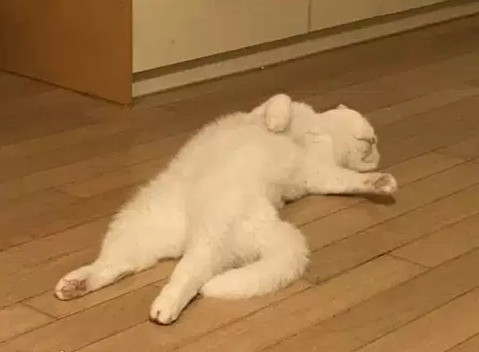